#**COVID-SegNet Implementation**

Implementation of the paper:

*COVID‑SegNet: encoder–decoder‑based architecture for COVID‑19
lesion segmentation in chest X‑ray*

Agrawal, T., Choudhary, P. COVID-SegNet: encoder–decoder-based architecture for COVID-19 lesion segmentation in chest X-ray. Multimedia Systems 29, 2111–2124 (2023). https://doi.org/10.1007/s00530-023-01096-9

*Attention:*

**This implementation is not original. It is due to educational purposes and may have differences comparing to what the paper offers.**

**For the original mindset and proposed architecture, please refer to the paper itself.**

##Initialization

In [ ]:
# import libraries
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import MeanIoU
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
import random

In [ ]:
# constants
IMG_HEIGHT = 224  # 224x224 input size
IMG_WIDTH = 224
IMG_CHANNELS = 3   # RGB
BATCH_SIZE = 8
EPOCHS = 20    # 50; for faster and lighter process, fewer EPOCHS are considered
LEARNING_RATE = 1e-4

# setting paths
TRAIN_IMAGE_PATH = '/content/drive/MyDrive/QaTa-COV19-v2/Train-Set/Images'
TRAIN_MASK_PATH = '/content/drive/MyDrive/QaTa-COV19-v2/Train-Set/Ground-truths'
TEST_IMAGE_PATH = '/content/drive/MyDrive/QaTa-COV19-v2/Test-Set/Images'
TEST_MASK_PATH = '/content/drive/MyDrive/QaTa-COV19-v2/Test-Set/Ground-truths'

##Loading and preprocessing the Data

In [ ]:
# loading and preprocessing
def load_data(image_path, mask_path, sample_fraction=1.0):

    # sorted files
    image_names = sorted(os.listdir(image_path))
    mask_names = sorted(os.listdir(mask_path))

    # sample fraction; random sample reduction for faster and lighter process (if needed)
    if sample_fraction < 1.0:
        num_samples = int(len(image_names) * sample_fraction)

        indices = list(range(len(image_names)))
        random.shuffle(indices)
        sample_indices = indices[:num_samples]

        image_names = [image_names[i] for i in sample_indices]
        mask_names = [mask_names[i] for i in sample_indices]


    images = []
    masks = []

    for img_name, mask_name in zip(image_names, mask_names):
        # load image
        img = cv2.imread(os.path.join(image_path, img_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
        img = img / 255.0  # normalize
        images.append(img)

        # load mask
        mask = cv2.imread(os.path.join(mask_path, mask_name), cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH))
        mask = (mask > 127).astype(np.float32)  # binarize
        masks.append(np.expand_dims(mask, axis=-1))  # add channel dimension

    return np.array(images), np.array(masks)


##COVID-SegNet Architecture and its Components

In [ ]:
# convolutional block with BatchNorm and ReLU
def conv_block(input_tensor, num_filters):

    # first convolution
    x = Conv2D(num_filters, 3, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # second convolution
    x = Conv2D(num_filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x


# encoder block with pooling
def encoder_block(input_tensor, num_filters):

    x = conv_block(input_tensor, num_filters)
    p = MaxPooling2D((2, 2))(x)    # downsampling

    return x, p


# decoder block with transposed conv
def decoder_block(input_tensor, skip_features, num_filters):

    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding='same')(input_tensor)    # upsampling
    x = concatenate([x, skip_features])
    x = conv_block(x, num_filters)

    return x


# build COVID-SegNet model
def build_covid_segnet():

    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

    # encoder
    s1, p1 = encoder_block(inputs, 64)    # block 1
    s2, p2 = encoder_block(p1, 128)    # block 2
    s3, p3 = encoder_block(p2, 256)    # block 3

    # bridge
    b1 = conv_block(p3, 512)

    # decoder
    d1 = decoder_block(b1, s3, 256)    # block 1
    d2 = decoder_block(d1, s2, 128)    # block 2
    d3 = decoder_block(d2, s1, 64)    # block 3

    # output
    outputs = Conv2D(1, 1, activation='sigmoid')(d3)

    model = Model(inputs=inputs, outputs=outputs)

    return model

##Metric Design

In [ ]:
# dice coefficient metric
def dice_coef(y_true, y_pred):

    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)

    return (2.0 * intersection + 1.0) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + 1.0)

##Processing

In [ ]:
# load train and test data
train_images, train_masks = load_data(TRAIN_IMAGE_PATH, TRAIN_MASK_PATH, sample_fraction=0.07)
test_images, test_masks = load_data(TEST_IMAGE_PATH, TEST_MASK_PATH, sample_fraction=0.07)

In [ ]:
# train/validation split
train_images, val_images, train_masks, val_masks = train_test_split(
    train_images, train_masks, test_size=0.2, random_state=42
)

In [ ]:
print('Data shape:')
print(f'Train images: {train_images.shape}, masks: {train_masks.shape}')
print(f'Validation images: {val_images.shape}, masks: {val_masks.shape}')
print(f'Test images: {test_images.shape}, masks: {test_masks.shape}')

Data shape:
Train images: (400, 224, 224, 3), masks: (400, 224, 224, 1)
Validation images: (100, 224, 224, 3), masks: (100, 224, 224, 1)
Test images: (147, 224, 224, 3), masks: (147, 224, 224, 1)


In [ ]:
# build and compile model
model = build_covid_segnet()
model.compile(
    optimizer=Adam(LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=['accuracy', MeanIoU(num_classes=2), dice_coef]
    )

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 224, 224,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 224, 224,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 224, 224,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 224, 224,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 112, 112,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 112, 112,  │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │      1,024 │ conv2d_4[0][0]  

 Total params: 7,708,609 (29.41 MB)

 Trainable params: 7,702,977 (29.38 MB)

 Non-trainable params: 5,632 (22.00 KB)

In [ ]:
# callbacks
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', save_best_only=True),
    ReduceLROnPlateau(factor=0.1, patience=5)
]

In [ ]:
# train model
history = model.fit(
    train_images, train_masks,
    validation_data=(val_images, val_masks),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks
    )


Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.8492 - dice_coef: 0.2487 - loss: 0.4158 - mean_io_u: 0.4401

50/50 ━━━━━━━━━━━━━━━━━━━━ 65s 542ms/step - accuracy: 0.8497 - dice_coef: 0.2496 - loss: 0.4146 - mean_io_u: 0.4401 - val_accuracy: 0.8766 - val_dice_coef: 0.1884 - val_loss: 0.6135 - val_mean_io_u: 0.4383 - learning_rate: 1.0000e-04
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.8987 - dice_coef: 0.3642 - loss: 0.2685 - mean_io_u: 0.4411

50/50 ━━━━━━━━━━━━━━━━━━━━ 42s 307ms/step - accuracy: 0.8988 - dice_coef: 0.3647 - loss: 0.2683 - mean_io_u: 0.4411 - val_accuracy: 0.8766 - val_dice_coef: 0.1756 - val_loss: 0.5018 - val_mean_io_u: 0.4383 - learning_rate: 1.0000e-04
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.9101 - dice_coef: 0.4567 - loss: 0.2312 - mean_io_u: 0.4350

50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 312ms/step - accuracy: 0.9101 - dice_coef: 0.4564 - loss: 0.2311 - mean_io_u: 0.4351 - val_accuracy: 0.8766 - val_dice_coef: 0.1357 - val_loss: 0.4053 - val_mean_io_u: 0.4383 - learning_rate: 1.0000e-04
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.9122 - dice_coef: 0.4746 - loss: 0.2148 - mean_io_u: 0.4390

50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 313ms/step - accuracy: 0.9122 - dice_coef: 0.4745 - loss: 0.2147 - mean_io_u: 0.4390 - val_accuracy: 0.8766 - val_dice_coef: 0.1276 - val_loss: 0.3858 - val_mean_io_u: 0.4383 - learning_rate: 1.0000e-04
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.9285 - dice_coef: 0.5127 - loss: 0.1838 - mean_io_u: 0.4406

50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 318ms/step - accuracy: 0.9284 - dice_coef: 0.5127 - loss: 0.1839 - mean_io_u: 0.4406 - val_accuracy: 0.8765 - val_dice_coef: 0.1417 - val_loss: 0.3683 - val_mean_io_u: 0.4383 - learning_rate: 1.0000e-04
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.9336 - dice_coef: 0.5316 - loss: 0.1728 - mean_io_u: 0.4417

50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 320ms/step - accuracy: 0.9335 - dice_coef: 0.5316 - loss: 0.1730 - mean_io_u: 0.4417 - val_accuracy: 0.8617 - val_dice_coef: 0.2311 - val_loss: 0.3600 - val_mean_io_u: 0.4383 - learning_rate: 1.0000e-04
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.9269 - dice_coef: 0.5420 - loss: 0.1770 - mean_io_u: 0.4402

50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 319ms/step - accuracy: 0.9270 - dice_coef: 0.5423 - loss: 0.1769 - mean_io_u: 0.4402 - val_accuracy: 0.8737 - val_dice_coef: 0.3066 - val_loss: 0.3161 - val_mean_io_u: 0.4383 - learning_rate: 1.0000e-04
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.9340 - dice_coef: 0.5574 - loss: 0.1630 - mean_io_u: 0.4436

50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 316ms/step - accuracy: 0.9340 - dice_coef: 0.5574 - loss: 0.1631 - mean_io_u: 0.4435 - val_accuracy: 0.8844 - val_dice_coef: 0.4249 - val_loss: 0.2788 - val_mean_io_u: 0.4383 - learning_rate: 1.0000e-04
Epoch 9/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.9334 - dice_coef: 0.5829 - loss: 0.1610 - mean_io_u: 0.4405

50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 319ms/step - accuracy: 0.9335 - dice_coef: 0.5830 - loss: 0.1609 - mean_io_u: 0.4405 - val_accuracy: 0.9104 - val_dice_coef: 0.4227 - val_loss: 0.2255 - val_mean_io_u: 0.4383 - learning_rate: 1.0000e-04
Epoch 10/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.9363 - dice_coef: 0.5866 - loss: 0.1546 - mean_io_u: 0.4405

50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 317ms/step - accuracy: 0.9364 - dice_coef: 0.5869 - loss: 0.1545 - mean_io_u: 0.4405 - val_accuracy: 0.9178 - val_dice_coef: 0.5311 - val_loss: 0.2092 - val_mean_io_u: 0.4383 - learning_rate: 1.0000e-04
Epoch 11/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.9390 - dice_coef: 0.5924 - loss: 0.1488 - mean_io_u: 0.4436

50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 317ms/step - accuracy: 0.9390 - dice_coef: 0.5925 - loss: 0.1489 - mean_io_u: 0.4435 - val_accuracy: 0.9369 - val_dice_coef: 0.5592 - val_loss: 0.1728 - val_mean_io_u: 0.4383 - learning_rate: 1.0000e-04
Epoch 12/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 310ms/step - accuracy: 0.9399 - dice_coef: 0.6214 - loss: 0.1459 - mean_io_u: 0.4377 - val_accuracy: 0.9209 - val_dice_coef: 0.5904 - val_loss: 0.2045 - val_mean_io_u: 0.4383 - learning_rate: 1.0000e-04
Epoch 13/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 307ms/step - accuracy: 0.9433 - dice_coef: 0.6283 - loss: 0.1389 - mean_io_u: 0.4406 - val_accuracy: 0.9244 - val_dice_coef: 0.5203 - val_loss: 0.1786 - val_mean_io_u: 0.4383 - learning_rate: 1.0000e-04
Epoch 14/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.9469 - dice_coef: 0.6693 - loss: 0.1306 - mean_io_u: 0.4367

50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 318ms/step - accuracy: 0.9469 - dice_coef: 0.6692 - loss: 0.1305 - mean_io_u: 0.4368 - val_accuracy: 0.9453 - val_dice_coef: 0.6227 - val_loss: 0.1473 - val_mean_io_u: 0.4383 - learning_rate: 1.0000e-04
Epoch 15/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.9513 - dice_coef: 0.6803 - loss: 0.1228 - mean_io_u: 0.4374

50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 321ms/step - accuracy: 0.9512 - dice_coef: 0.6800 - loss: 0.1228 - mean_io_u: 0.4375 - val_accuracy: 0.9432 - val_dice_coef: 0.6263 - val_loss: 0.1451 - val_mean_io_u: 0.4383 - learning_rate: 1.0000e-04
Epoch 16/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.9519 - dice_coef: 0.6788 - loss: 0.1195 - mean_io_u: 0.4412

50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 319ms/step - accuracy: 0.9519 - dice_coef: 0.6790 - loss: 0.1195 - mean_io_u: 0.4411 - val_accuracy: 0.9457 - val_dice_coef: 0.6302 - val_loss: 0.1352 - val_mean_io_u: 0.4383 - learning_rate: 1.0000e-04
Epoch 17/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 308ms/step - accuracy: 0.9502 - dice_coef: 0.6900 - loss: 0.1231 - mean_io_u: 0.4370 - val_accuracy: 0.9462 - val_dice_coef: 0.6615 - val_loss: 0.1365 - val_mean_io_u: 0.4383 - learning_rate: 1.0000e-04
Epoch 18/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.9587 - dice_coef: 0.7023 - loss: 0.1041 - mean_io_u: 0.4424

50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 317ms/step - accuracy: 0.9587 - dice_coef: 0.7026 - loss: 0.1042 - mean_io_u: 0.4424 - val_accuracy: 0.9470 - val_dice_coef: 0.6472 - val_loss: 0.1288 - val_mean_io_u: 0.4383 - learning_rate: 1.0000e-04
Epoch 19/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 308ms/step - accuracy: 0.9563 - dice_coef: 0.7012 - loss: 0.1105 - mean_io_u: 0.4392 - val_accuracy: 0.9481 - val_dice_coef: 0.6808 - val_loss: 0.1351 - val_mean_io_u: 0.4383 - learning_rate: 1.0000e-04
Epoch 20/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 308ms/step - accuracy: 0.9598 - dice_coef: 0.7341 - loss: 0.1032 - mean_io_u: 0.4377 - val_accuracy: 0.9264 - val_dice_coef: 0.5267 - val_loss: 0.1952 - val_mean_io_u: 0.4383 - learning_rate: 1.0000e-04


In [ ]:
# evaluate
test_results = model.evaluate(test_images, test_masks)
print('Results:')
print(f'Test Loss: {test_results[0]:.4f}')
print(f'Test Accuracy: {test_results[1]:.4f}')
print(f'Test IoU: {test_results[2]:.4f}')
print(f'Test Dice: {test_results[3]:.4f}')

5/5 ━━━━━━━━━━━━━━━━━━━━ 37s 4s/step - accuracy: 0.9457 - dice_coef: 0.6859 - loss: 0.1298 - mean_io_u: 0.4349
Results:
Test Loss: 0.1311
Test Accuracy: 0.9453
Test IoU: 0.4351
Test Dice: 0.6821


##Visualization

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


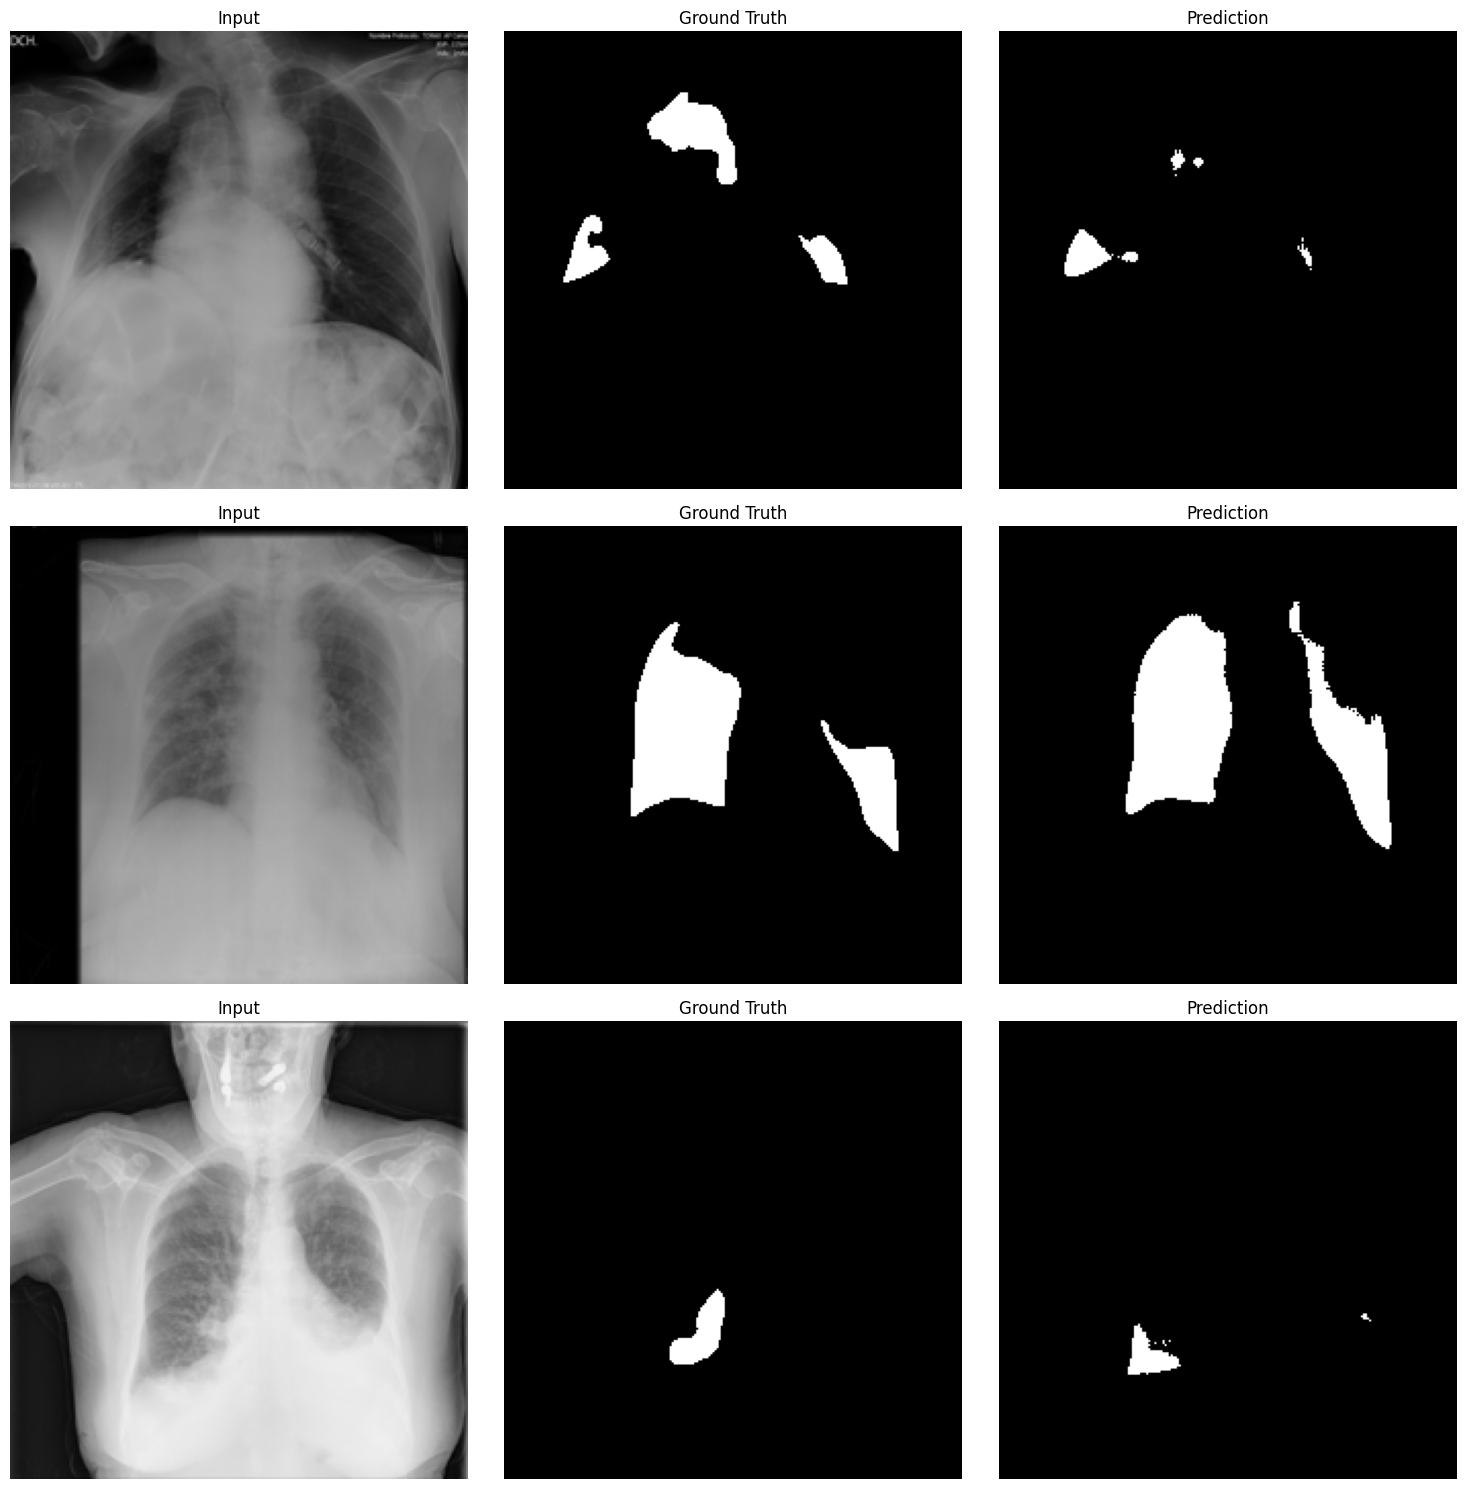

In [ ]:
# data visualization
def visualize_predictions(model, images, masks, num_samples=3):

    preds = model.predict(images[:num_samples])
    preds = (preds > 0.5).astype(np.float32)

    plt.figure(figsize=(15, 5 * num_samples))
    for i in range(num_samples):
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(images[i])
        plt.title('Input')
        plt.axis('off')

        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title('Ground Truth')
        plt.axis('off')

        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(preds[i].squeeze(), cmap='gray')
        plt.title('Prediction')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_predictions(model, test_images, test_masks)